# This code is used to create subplots of Figure 6 and S5 of Ruff, Choi et al.

## Import all modules needed

In [14]:
import pandas as pd
import numpy as np
import math
import os
import seaborn as sbn
import random
import xlsxwriter

import matplotlib.pyplot as plt
from matplotlib import cm
from matplotlib.colors import ListedColormap, LinearSegmentedColormap

import scipy
from scipy.stats import ttest_1samp
from scipy.spatial.distance import pdist, squareform
import scipy.spatial as sp, scipy.cluster.hierarchy as hc
from scipy.stats import ks_2samp

from loguru import logger
logger.info('Import OK')

import localcider
from localcider.sequenceParameters import SequenceParameters
import re

2022-04-12 13:53:11.731 | INFO     | __main__:<module>:19 - Import OK


## Section 1: Plot data for Figure 6D 

Here, we define the z-score matrix of abundance data for the top 94 differentially enriched proteins. We then use a smoothing function on this data to highlight significant changes in abundance. Finally we plot the data as a hierarchically-clustered heatmap.

### Load in the abundance data for the top 94 differently expressed enodgenous proteins upon removal of the barnase constructs & calculate z-score

In [3]:
# Load in abundance data
myfile='../../data/UPOD_proteomics/Table_S5.xlsx'
df=pd.read_excel(myfile,'remove_barnase_5_CON') # removes the 5 proteins associated with barnase
#print(df)

accs = df['Proteins'].tolist()

df2=df.pop('Proteins')

colnames = df.columns
dfmat=df.values

# Get individual variants
reps=4
num_var=8
ucolnames=[]
for i in range(0,num_var):
    tmp=colnames[reps*i].split('_')
    ucolnames.append(tmp[0])

# Map accs to gene names
f=open('../../data/UPOD_proteomics/Gene_mapping_list.txt',"r")
lines=f.readlines()
mapacc=[]
mapgene=[]
for line in lines:
    cleanline = line.strip()
    mapacc.append(cleanline.split('\t')[0])
    mapgene.append(cleanline.split('\t')[1])

genenames=[]
for a in accs:
    curridx=mapacc.index(a)
    genenames.append(mapgene[curridx])

# Create log10 z-score matrix
zmat=[]
for r in dfmat:
    ztmp=[]
    for i in r:
        ztmp.append(math.log10(i))
    zmat.append(ztmp)

zmat2=[]
for r in zmat:
    ztmp=[]
    for i in r:
        ztmp.append((i-np.mean(r))/np.std(r))
    zmat2.append(ztmp)

### Define definitions for smoothing the z-score matrix

In [4]:
def one_sample_ttest(compiled, sample_cols, group_cols, popmean=1):
    df = compiled.copy()
    ttest_results = []
    for group_key, df in df.groupby(group_cols):
        results = []
        for col in sample_cols:
            test_vals = df[col].values
            if len(test_vals) > 1:
                results.append(
                    tuple(ttest_1samp(test_vals, popmean=popmean, nan_policy='omit')))
            else:
                results.append((np.nan, np.nan))
        results = pd.DataFrame(results)
        results.columns = ['t-stat', 'p-val']
        results['conc'] = sample_cols
        for x, col in enumerate(group_cols):
            results[col] = group_key[x]
        ttest_results.append(results)
    ttest_results = pd.concat(ttest_results)
    ttest_results[['t-stat', 'p-val']
                  ] = ttest_results[['t-stat', 'p-val']].astype(float)

    return ttest_results  # 5% of the points detected as significantly different


def pval_smoothing(compiled, sample_cols, group_cols, popmean, penalty_factor=20, zero_norm=False):
    """Scale mean value proportional to pvalue, imposing penalty for variability

    Parameters
    ----------
    compiled : DataFrame
        Longoform pandas df containing descriptive columns (group_cols) and data columns (sample_cols),
        where replicates of each datapoint are stored in columns.
    sample_cols : list[str]
        List of column names where quantitative data can be found. Replicate data points should 
        be contained wholly within single columns
    group_cols : list[str]
        List of column names to group ```compiled``` of, such that grouped df for each group is 
        length of replicates 
    popmean : int
        Hypothesised population mean. Typically, for ratiometric analyses this may be 1 or 0, however 
        can be any value to which samples will be compared
    penalty_factor : int, optional
        Weight to which p-value will be scaled, by default 20. Larger value imposes more severe 
        scaling of the mean value with increased p-value.
    zero_norm : bool, optional
        When smoothing values which have been normalised to a given sample e.g. time 0 normalisation, 
        all entries for the sample used as a normalisation factor will be the same. In the case of 
        samples normalised to 0, then the normalisation sample will return NaN for the pvalue which 
        is then propogated to the final value dataframe. Setting this option to True restores the 0 
        values for samples which are all 0. By default False.

    Returns
    -------
    DataFrame
        Smoothed dataframe where replicates have been reduced to the mean value, 
        scaled by p-value smoothing.
    """
    # Apply t-test to sample
    ttest_results = one_sample_ttest(
        compiled, sample_cols, group_cols=group_cols, popmean=popmean)
    # Generate scaling factors
    ttest_results['exp_p-val'] = penalty_factor**ttest_results['p-val']
    p_vals = pd.pivot_table(
        ttest_results, values='exp_p-val', index=group_cols, columns='conc')

    # Calculate mean of the input df
    proportional_pval = compiled.groupby(
        group_cols).mean().copy().sort_values(group_cols)
    for col in sample_cols:
        if col in p_vals.columns.tolist():
            # apply scaling factor to means
            proportional_pval[col] = popmean + (proportional_pval[col] - popmean) * (
                1 / p_vals.sort_values(group_cols)[col])
    if zero_norm == True:
        proportional_pval[0.0] = 0

    return proportional_pval

### Smooth z-score matrix data

In [6]:
# Convert z-score matrix to a format that can be used for smoothing
dfforsmooth=pd.DataFrame()
st=[0,4,8,12,16,20,24,28,32]

countacc=-1
zsvals=[]
acclist=[]
genelist=[]
mutname=[]
for r in zmat2:
    countacc=countacc+1
    for i in range(0,len(st)-1):
        for j in range(st[i],st[i+1]):
            zsvals.append(r[j])
            acclist.append(accs[countacc])
            genelist.append(genenames[countacc])
            mutname.append(ucolnames[i])

#dfforsmooth['protein']=acclist # if want proteins in terms of accessions
dfforsmooth['protein']=genelist # if want proteins in terms of gene names
dfforsmooth['dataset']=mutname
dfforsmooth['value']=zsvals
            
print(dfforsmooth)

# Apply smoothing
smoothing_factor = 20
smoothed_data = pval_smoothing(
    dfforsmooth,
    sample_cols=['value'],
    group_cols=['dataset', 'protein'],
    popmean=0,
    penalty_factor=smoothing_factor,
    zero_norm=False
)

# Save to excel
smoothed_data.to_csv('../../data/UPOD_proteomics/scaled_data.csv')
print(smoothed_data)

     protein dataset     value
0      RBM17      3S -0.934024
1      RBM17      3S -0.182982
2      RBM17      3S  0.087327
3      RBM17      3S -0.376522
4      RBM17      4Y -1.697397
...      ...     ...       ...
3003    MCM5    L14A  0.553434
3004    MCM5      WT  1.341899
3005    MCM5      WT  0.752335
3006    MCM5      WT  0.513513
3007    MCM5      WT  1.501919

[3008 rows x 3 columns]
                         value
dataset protein               
3S      ACAD8        -0.445643
        ADK          -0.377593
        AK4           0.972665
        ANKRD55       0.012659
        ANXA6         0.042889
...                        ...
WT      UBE2N/UBE2NL  0.017034
        UBXN1        -1.923758
        WDR77        -1.389183
        YBX1/2        1.606822
        YKT6          0.499092

[752 rows x 1 columns]


### Plot clustermap of smoothed data - Figure 6D

dataset             3S        4Y      8ala        9S       Ex4        FY  \
protein                                                                    
ACAD8        -0.445643  0.839841  1.059695 -0.723339 -0.453696  1.440607   
ADK          -0.377593 -0.035531 -0.206533 -0.151322 -0.001643  2.430833   
AK4           0.972665  0.841209  1.173244  0.330020 -0.855656 -0.567805   
ANKRD55       0.012659  0.042436  0.364736 -0.405745  0.197953  0.971667   
ANXA6         0.042889  0.055903  0.277073 -0.490501  0.228677  0.816640   
...                ...       ...       ...       ...       ...       ...   
UBE2N/UBE2NL -0.303612  1.727958 -0.799969  0.015599  0.064344 -0.762253   
UBXN1         0.282298  0.016403  0.104626 -0.506358  0.252211  0.897393   
WDR77        -0.000033  0.047075  0.056357 -0.253885  0.186692  0.839682   
YBX1/2       -0.109492  0.257563 -0.350406  0.008849 -0.098780 -0.454346   
YKT6         -0.324266  0.397491 -0.916648  0.586154  0.303815 -0.987961   

dataset    

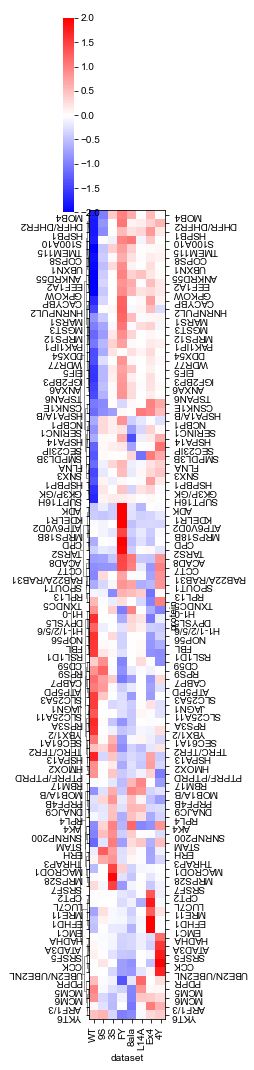

In [7]:
# Load in csv data
dftmp=pd.read_csv('../../data/UPOD_proteomics/scaled_data.csv')
currproteins=dftmp['protein'].tolist()[0:94]
pivoted = dftmp.pivot(index='protein', columns='dataset', values='value')
print(pivoted)

dfmean = pivoted[['WT','9S','3S','FY','8ala','L14A','Ex4','4Y']]

#g = sbn.clustermap(dfmean, metric="euclidean", method="ward", cmap='bwr',vmin=-2, vmax=2,figsize=(8, 15),yticklabels=1,xticklabels=1,col_cluster=False,linewidths=1, linecolor='grey')
g = sbn.clustermap(dfmean, metric="euclidean", method="ward", cmap='bwr',vmin=-2, vmax=2,figsize=(3, 15),yticklabels=1,xticklabels=1,col_cluster=False)


clusters = scipy.cluster.hierarchy.fcluster(g.dendrogram_row.linkage, 2.5, 'distance')
numclust=max(clusters)
print(clusters)

for c in range(1,numclust+1):
    print(c)
    pos=[i for i, ltr in enumerate(clusters) if ltr == c]
    #print(pos)

    geneclust=[]
    for p in pos: 
        geneclust.append(currproteins[p])
    
    print(geneclust)
    currdf=pd.DataFrame()
    currdf['Genes']=geneclust
    
    #if c==1:
    #    with pd.ExcelWriter('../data/barnase_log10_zscore_abundance_clusters.xlsx') as writer:  
    #        currdf.to_excel(writer, sheet_name='cluster_'+str(c))
    #else:
    #    with pd.ExcelWriter('../data/barnase_log10_zscore_abundance_clusters.xlsx',engine="openpyxl",mode='a') as writer:  
    #        currdf.to_excel(writer, sheet_name='cluster_'+str(c))


# add gene names to each side 
y_labels_ticks = g.ax_heatmap.get_yticklabels()

ax2=g.ax_heatmap.twinx()
ax2.set_ylim(g.ax_heatmap.get_ylim()) 
ax2.set_yticks(g.ax_heatmap.get_yticks())


y2_labels_ticks = g.ax_heatmap.get_yticklabels()

# re set the tick labels with the modified list
g.ax_heatmap.set_yticklabels(y_labels_ticks)
plt.setp(g.ax_heatmap.get_yticklabels(), rotation=180)
ax2.set_yticklabels(y2_labels_ticks)
plt.setp(ax2.get_yticklabels(), rotation=180)

#plt.setp(clust_map.ax_heatmap.get_xticklabels(), rotation=90)

plt.rcParams['pdf.fonttype'] = 42 # Makes text editiable
plt.rcParams['ps.fonttype'] = 42
plt.rcParams['font.sans-serif'] = "Arial"
plt.rcParams['font.family'] = "sans-serif"
#plt.savefig('Fig_6_Abundance_zscore_heatmap.pdf', dpi=300, transparent=True, bbox_inches='tight')

# Section 2: Plot data for Figures 6E & 6F

The next several sections are necessary to determine the sequence features of each of the top differentially enriched proteins and to see if any sequence features are enriched / depleted in different sets of differently enriched proteins in different groups of barnase variants.

### Get Patterning of Residue Types - Modified version of NARDINI

First we need to determine the patterning of different residue types. This is a modified version of NARDINI by Cohan et al., (https://doi.org/10.1016/j.jmb.2021.167373). Here, the underlying distribution of comparison is a 1000 random scrambles of each sequence.

In [ ]:
# import random
# import numpy as np
# import matplotlib.pyplot as plt
# import localcider
# from localcider.sequenceParameters import SequenceParameters

# def get_kappa(seq,type1,type2):
#     blobsz=[5,6]
#     kappab=[]
#     for b in blobsz:
#         # Get full sequence asymmetry
#         count1=0
#         for res in type1: 
#             count1=count1+myseq.count(res)
        
#         count2=0    
#         for res in type2: 
#             count2=count2+myseq.count(res)
            
#         sigAll=((count1/len(myseq))-(count2/len(myseq)))**2/((count1/len(myseq))+(count2/len(myseq)))
        
#         # Get asymmetry for each blob
#         sigX=[]
#         for x in range(0,len(myseq)-b+1):
#             subseq=seq[x:x+b]
            
#             count1=0
#             for res in type1:
#                 count1=count1+subseq.count(res)
                
#             count2=0
#             for res in type2:
#                 count2=count2+subseq.count(res)
            
#             if count1+count2==0:
#                 sigX.append(0)
#             else:
#                 sigX.append(((count1/b)-(count2/b))**2/((count1/b)+(count2/b)))
        
#         asym=[]
#         for x in range(0,len(sigX)):
#             asym.append((sigX[x]-sigAll)**2)
        
#         kappab.append(np.mean(asym))
   
#     kappa=np.mean(kappab)
#     return kappa 

    
# def get_omega(seq,type1):
#     blobsz=[5,6]
#     omegab=[]
#     for b in blobsz:
#         # Get full sequence asymmetry
#         count=0
#         for res in type1: 
#             count=count+myseq.count(res)
            
#         sigAll=((count/len(myseq))-(1-(count/len(myseq))))**2
        
#         # Get asymmetry for each blob
#         sigX=[]
#         for x in range(0,len(myseq)-b+1):
#             count=0
#             subseq=seq[x:x+b]
#             for res in type1:
#                 count=count+subseq.count(res)
                
#             sigX.append(((count/b)-(1-(count/b)))**2)
        
#         asym=[]
#         for x in range(0,len(sigX)):
#             asym.append((sigX[x]-sigAll)**2)
        
#         omegab.append(np.mean(asym))
   
#     omega=np.mean(omegab)
#     return omega   
                
        
        
# def get_org_seq_vals(myseq,typeall,fracsall):
    
#     org_seq_arr = np.zeros((len(typeall),len(typeall)))
    
#     for count1 in range(0,len(typeall)):
#         type1 = typeall[count1]

#         for count2 in range(count1,len(typeall)):
#             type2 = typeall[count2]

#             if type1 == type2 and fracsall[count1]>0.12:
#                 org_seq_arr[count1, count2]=get_omega(myseq,type1)
                
#             if type1 != type2 and fracsall[count1]>0.10 and fracsall[count2]>0.10:
#                 org_seq_arr[count1, count2]=get_kappa(myseq,type1,type2)
    
#     org_seq_1d=org_seq_arr.reshape([1, len(typeall)**2])
#     return org_seq_1d


# def get_scramble_seqs_vals(myseq,num_seqs,typeall,fracsall):
    
#     currseq=[]
#     scr_vals=np.zeros((num_seqs,len(typeall)**2))
    
#     for x in range(0,num_seqs):
#         currseq=''.join(random.sample(myseq,len(myseq)))
        
#         scr_seq_arr = np.zeros((len(typeall),len(typeall)))
    
#         for count1 in range(0,len(typeall)):
#             type1 = typeall[count1]

#             for count2 in range(count1,len(typeall)):
#                 type2 = typeall[count2]

#                 if type1 == type2 and fracsall[count1]>0.12:
#                     scr_seq_arr[count1, count2]=get_omega(currseq,type1)

#                 if type1 != type2 and fracsall[count1]>0.10 and fracsall[count2]>0.10:
#                     scr_seq_arr[count1, count2]=get_kappa(currseq,type1,type2)
        
#         scr_vals[x,0:len(typeall)**2] = scr_seq_arr.reshape([1, len(typeall)**2])
    
#     mval=np.mean(scr_vals, axis=0)
#     sval=np.std(scr_vals, axis=0)
#     return [mval,sval]
    

# ####### SCRIPT STARTS HERE ####### 

# # Get list of sequences
# myfile='../data/top_100_proteins.fasta'

# with open(myfile,'r') as f:
#     content = f.readlines()
  
#     thisseq = ''
#     orthseqs = []
#     acc=[]
#     for line in content:
    
#         # remove pesky newline
#         cleanline = line.strip()

#         # if new sequence
#         if (cleanline[:1] == '>'):
#             currline=cleanline.split('|')
#             acc.append(currline[1])
#             # check that this is not the very first sequence, if not 
#             # add the sequence
#             if (thisseq != ''): 
#                 orthseqs.append(thisseq.upper())
#             # reset the sequence for the coming entry
#             thisseq = '' 

#         # else append the sequence
#         else:
#             thisseq += cleanline 
            
#     # store the final sequence	
#     orthseqs.append(thisseq.upper())

# #print(acc)
# #print(orthseqs)
    
# num_seqs=1000

# pol=['S','T','N','Q','C','H']
# hyd=['I','L','M','V']
# pos=['R','K']
# neg=['E','D']
# aro=['F','W','Y']
# ala=['A']
# pro=['P']
# gly=['G']

# typeall=[pol,hyd,pos,neg,aro,ala,pro,gly]

# zvec=np.zeros((len(orthseqs),int(len(typeall)+(len(typeall)*(len(typeall)-1))/2)))
# zvecdb=np.zeros((len(orthseqs),len(typeall)**2))

# countseqs=-1
# for myseq in orthseqs:
#     print(myseq)
#     fracsall=[]
#     countseqs=countseqs+1
#     for type1 in typeall:
#         mycount=0
#         for res in type1:
#             mycount=mycount+myseq.count(res)
#         fracsall.append(mycount/len(myseq))

#     print(fracsall)

#     myarr=get_org_seq_vals(myseq,typeall,fracsall)

#     [meanvals,stdvals]=get_scramble_seqs_vals(myseq,num_seqs,typeall,fracsall)
    
#     # Each pair counted once
#     countpairs=-1
#     countall=-1
#     for x in range(0,len(typeall)):
#         for y in range(0,len(typeall)):
#             countall=countall+1
#             if y>=x:
#                 countpairs=countpairs+1
#                 if myarr[0,countall]==0:
#                     zvec[countseqs,countpairs]=0
#                 else:
#                     zvec[countseqs,countpairs]=(myarr[0,countall]-meanvals[countall])/stdvals[countall]
    

#     # Each pair counted twice so can make full 8x8 matrix
#     for x in range(0,myarr.shape[1]):
#         if myarr[0,x]==0:
#             zvecdb[countseqs,x]=0
#         else:
#             zvecdb[countseqs,x]=(myarr[0,x]-meanvals[x])/stdvals[x]


# # If more than one sequence
# fig, ax = plt.subplots(1,1)
# fig.set_size_inches(15,1)
# img = ax.imshow(zvec,vmin=-3, vmax=3, cmap='RdBu',aspect='auto')
# fig.colorbar(img)

# # If only one sequence            
# fig, ax = plt.subplots(1,1)
# img = ax.imshow(np.array(zvecdb[0,:]).reshape([len(typeall), len(typeall)]),vmin=-3, vmax=3, cmap='RdBu', aspect='auto')
# fig.colorbar(img)
# x_label_list = ['pol', 'hyd', 'pos', 'neg','aro','ala','pro','gly']
# ax.set_xticks([0,1,2,3,4,5,6,7])
# ax.set_xticklabels(x_label_list)
# ax.set_yticks([0,1,2,3,4,5,6,7])
# ax.set_yticklabels(x_label_list)

### Load in Values of Patterning of Residue Types

The code above involves generating random scrambles so we run it once and then used the saved data for all the other analyses.

In [9]:
#np.save('../../data/UPOD_proteomics/patterning_zvec_1000_random_seqs',zvec) # saved patterning z-score vector
zvec=np.load('../../data/UPOD_proteomics/patterning_zvec_1000_random_seqs.npy')

# Get list of sequences
myfile='../../data/UPOD_proteomics/top_100_proteins.fasta'

with open(myfile,'r') as f:
    content = f.readlines()
  
    thisseq = ''
    orthseqs = []
    acc=[]
    for line in content:
    
        # remove pesky newline
        cleanline = line.strip()

        # if new sequence
        if (cleanline[:1] == '>'):
            currline=cleanline.split('|')
            acc.append(currline[1])
            # check that this is not the very first sequence, if not 
            # add the sequence
            if (thisseq != ''): 
                orthseqs.append(thisseq.upper())
            # reset the sequence for the coming entry
            thisseq = '' 

        # else append the sequence
        else:
            thisseq += cleanline 
            
    # store the final sequence	
    orthseqs.append(thisseq.upper())

### Create Base Sequence Feature Set From All Proteins in Proteomics Dataset

To determine if certain compositional features are enriched / depleted in a given set of recruited proteins we need a base sequence set to compare to. Here, we use the full set of sequences in the proteomics dataset. This should help diminish any experimental biases that may occur compared to using the full human proteome as the base sequence set.

[0.07663693110479167, 0.016065021431814378, 0.05160202867403958, 0.07502419916502297, 0.03739858869819435, 0.06859665536071172, 0.022105875592891903, 0.047267441625610085, 0.07036680620260256, 0.09523216288261356, 0.0243071927401851, 0.035364908982868336, 0.05311469629554253, 0.044126108904317944, 0.06021518377554118, 0.06844095065589607, 0.04958077041995327, 0.06431396101037269, 0.01144141370790108, 0.02879910276912906, 0.13058198997814371, 0.12662622783906255, 0.3042802913484537, 0.3077576893635731, 0.07763910517522449, -0.05738221423434739, 0.14846755575594603, 0.3103229141127488, 0.2572082178172063, 0.003955762139081185, 4.086547471550173, 0.6398102061513113, 7.416735651214128, 0.36487129257816503, 0.010603344023693315, 0.00020761383956391917, 0.0028513748244202853, 0.01167924246333253, 0.0006625640952016899, 0.010082138080250885, 0.00027129748537239607, 0.0009015472936163088, 0.009701768367510556, 0.012395033789474704, 0.0005138669045890473, 0.0068861424863809395, 0.00209553084316

(array([1.000e+01, 3.200e+01, 3.150e+02, 1.097e+03, 6.390e+02, 1.330e+02,
        2.900e+01, 8.000e+00, 1.000e+00, 1.000e+00]),
 array([0.11764706, 0.16709908, 0.21655111, 0.26600313, 0.31545516,
        0.36490718, 0.4143592 , 0.46381123, 0.51326325, 0.56271528,
        0.6121673 ]),
 <BarContainer object of 10 artists>)

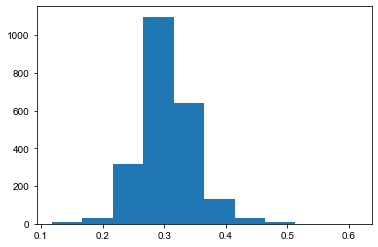

In [11]:
# Get compositional sequence features of base sequence set

numInt=2 # Number of allowable interruption residues
minBlockLen=4 # Must have at least minBlockLen lysines in the block

aas='ACDEFGHIKLNPQRSTVY' # For pathces - no M or W patch in proteome so this is removed
#aas='CEK'

# Compare to full proteome rather than just disordered proteome
myfile='../../data/UPOD_proteomics/all_reviewed_human_proteins_2015.fasta'

# Get list of all proteins in proteomics dataset
myfile2='../../data/UPOD_proteomics/filled_values_ini_norm.xlsx'
df=pd.read_excel(myfile2,'Sheet1')
paccs = df['Proteins'].tolist()
mabund = df['Mean Abundance'].tolist()

# Gets all sequences and accessions
with open(myfile,'r') as f:
    content = f.readlines()
  
    thisseq = ''
    fallseqs = []
    fallacc=[]
    for line in content:
    
        # remove pesky newline
        cleanline = line.strip()

        # if new sequence
        if (cleanline[:1] == '>'):
            currline=cleanline.split('|')
            fallacc.append(currline[1])
            # check that this is not the very first sequence, if not 
            # add the sequence
            if (thisseq != ''): 
                fallseqs.append(thisseq.upper())
            # reset the sequence for the coming entry
            thisseq = '' 

        # else append the sequence
        else:
            thisseq += cleanline 
            
    # store the final sequence	
    fallseqs.append(thisseq.upper())

# Creates of subset of sequences and accessions associated with the proteins in the proteomics dataset
allseqs=[]
allacc=[]
abundvec=[]
for a in fallacc:
    if a in paccs:
        allacc.append(a)
        pos=fallacc.index(a)
        allseqs.append(fallseqs[pos])
        pos2=paccs.index(a)
        abundvec.append(mabund[pos2])
    
fracA=[]
fracC=[]
fracD=[]
fracE=[]
fracF=[]
fracG=[]
fracH=[]
fracI=[]
fracK=[]
fracL=[]
fracM=[]
fracN=[]
fracP=[]
fracQ=[]
fracR=[]
fracS=[]
fracT=[]
fracV=[]
fracW=[]
fracY=[]
fracpos=[]
fracneg=[]
fracpol=[]
fracali=[]
fracaro=[]
fracRtoK=[]
fracEtoD=[]
fracexp=[]
fcr=[]
ncpr=[]
mhydro=[]
dispro=[]
isopoi=[]
ppii=[]
fracpatch=[[] for _ in range(len(aas))]
rgpatch=[]
fracRY=[]
numRY=[]

for currseq in allseqs:

    if len(currseq)>=30 and "X" not in currseq and "U" not in currseq and "Z" not in currseq and "J" not in currseq and "B" not in currseq and "O" not in currseq:
        SeqOb = SequenceParameters(currseq)
        slen=SeqOb.get_length()
        aafrac=SeqOb.get_amino_acid_fractions()

        fracexp.append(SeqOb.get_fraction_expanding())
        fcr.append(SeqOb.get_FCR())
        ncpr.append(SeqOb.get_NCPR())
        mhydro.append(SeqOb.get_mean_hydropathy())
        dispro.append(SeqOb.get_fraction_disorder_promoting())
        isopoi.append(SeqOb.get_isoelectric_point())
        ppii.append(SeqOb.get_PPII_propensity(mode='hilser'))

        ## AA Fractions
        fracA.append(aafrac['A'])
        fracC.append(aafrac['C'])
        fracD.append(aafrac['D'])
        fracE.append(aafrac['E'])
        fracF.append(aafrac['F'])
        fracG.append(aafrac['G'])
        fracH.append(aafrac['H'])
        fracI.append(aafrac['I'])
        fracK.append(aafrac['K'])
        fracL.append(aafrac['L'])
        fracM.append(aafrac['M'])
        fracN.append(aafrac['N'])
        fracP.append(aafrac['P'])
        fracQ.append(aafrac['Q'])
        fracR.append(aafrac['R'])
        fracS.append(aafrac['S'])
        fracT.append(aafrac['T'])
        fracV.append(aafrac['V'])
        fracW.append(aafrac['W'])
        fracY.append(aafrac['Y'])

        ## AA Physicochemical properties
        fracpos.append(aafrac['K']+aafrac['R'])
        fracneg.append(aafrac['D']+aafrac['E'])
        fracpol.append(aafrac['Q']+aafrac['N']+aafrac['S']+aafrac['T']+aafrac['G']+aafrac['C']+aafrac['H'])
        fracali.append(aafrac['A']+aafrac['L']+aafrac['M']+aafrac['I']+aafrac['V'])
        fracaro.append(aafrac['F']+aafrac['W']+aafrac['Y'])

        ## AA ratios
        fracRtoK.append(np.log10(((slen*aafrac['R'])+1)/((slen*aafrac['K'])+1)))
        fracEtoD.append(np.log10(((slen*aafrac['E'])+1)/((slen*aafrac['D'])+1)))

        ## Fraction of sequence containing patches
        counta=-1
        for a in aas:
            counta=counta+1
            justKs='0'*len(currseq) # Set string of zeros

            pos=[i for i, ltr in enumerate(currseq) if ltr == a] # Find positions of the residue of interest

            # If interruption length is less than or equal to numInt then say these positions are also the residue of interest
            pos2=pos
            for p in range(0,len(pos)-1):
                tdi=pos[p+1]-pos[p]
                if tdi > 1 and tdi<=numInt+1:
                    myt=list(range(pos[p]+1,pos[p+1]))
                    for item in myt:
                        pos2.append(item)


            # For positions make those 1 in string of zeros   
            justKs = list(justKs)
            for p in pos2:
                justKs[p]='1'
            justKs = ''.join(justKs)


            the_ones = re.findall(r"1+", justKs) # Find all consecutive 1s
            idx_ones=[[m.start(0), m.end(0)] for m in re.finditer(r"1+", justKs)] # Find indices of ones

            numpatches=0
            count=-1
            patchescombined=''
            for o in the_ones:
                count=count+1
                myrange=idx_ones[count] # Get indices for each consecutive strength
                subseq=currseq[myrange[0]:myrange[1]] # Get subseq that corresponds to this stength
                pos3=[i for i, ltr in enumerate(subseq) if ltr == a] # Get positions of the actual residue of interest in this subseq
                # If the number of the actual residue of interest is greater than or equal to minBlockLen add to the number of patches and string patches together in string
                if len(pos3)>=minBlockLen:
                    numpatches=numpatches+1
                    patchescombined+=subseq

            fracpatch[counta].append(len(patchescombined)/len(currseq))

            ## Fraction of sequence in RG stretch
            justKs='0'*len(currseq) # Set string of zeros
            pos=[i for i, ltr in enumerate(currseq) if ltr == 'R' or ltr == 'G'] # Find positions of Rs and Gs

            # If interruption length is less than or equal to numInt then say these positions are also the residue of interest
            pos2=pos
            for p in range(0,len(pos)-1):
                tdi=pos[p+1]-pos[p]
                if tdi > 1 and tdi<=numInt+1:
                    myt=list(range(pos[p]+1,pos[p+1]))
                    for item in myt:
                        pos2.append(item)

            # For positions make those 1 in string of zeros             
            justKs = list(justKs)
            for p in pos2:
                justKs[p]='1'
            justKs = ''.join(justKs)

            the_ones = re.findall(r"1+", justKs) # Find all consecutive 1s
            idx_ones=[[m.start(0), m.end(0)] for m in re.finditer(r"1+", justKs)] # Find indices of ones

            count=-1
            patchescombined=''
            for o in the_ones:
                count=count+1
                myrange=idx_ones[count] # Get indices for each consecutive strength
                subseq=currseq[myrange[0]:myrange[1]] # Get subseq that corresponds to this stength
                pos3=subseq.count('RG')
                #print(subseq)
                if pos3>=2:
                    patchescombined+=subseq

            rgpatch.append(len(patchescombined)/len(currseq))
            
            # Fraction & number of R / Y stickers - like the FET family protein analysis
            fracRY.append(aafrac['R']+aafrac['Y'])
            numRY.append(slen*(aafrac['R']+aafrac['Y']))

meanvals_sapiens=[np.mean(fracA), np.mean(fracC), np.mean(fracD), np.mean(fracE), np.mean(fracF), np.mean(fracG), np.mean(fracH), np.mean(fracI), np.mean(fracK), np.mean(fracL), np.mean(fracM), np.mean(fracN), np.mean(fracP), np.mean(fracQ), np.mean(fracR), np.mean(fracS), np.mean(fracT), np.mean(fracV), np.mean(fracW), np.mean(fracY), np.mean(fracpos), np.mean(fracneg), np.mean(fracpol), np.mean(fracali), np.mean(fracaro), np.mean(fracRtoK), np.mean(fracEtoD), np.mean(fracexp), np.mean(fcr), np.mean(ncpr), np.mean(mhydro), np.mean(dispro), np.mean(isopoi), np.mean(ppii)]
stdvals_sapiens=[np.std(fracA), np.std(fracC), np.std(fracD), np.std(fracE), np.std(fracF), np.std(fracG), np.std(fracH), np.std(fracI), np.std(fracK), np.std(fracL), np.std(fracM), np.std(fracN), np.std(fracP), np.std(fracQ), np.std(fracR), np.std(fracS), np.std(fracT), np.std(fracV), np.std(fracW), np.std(fracY), np.std(fracpos), np.std(fracneg), np.std(fracpol), np.std(fracali), np.std(fracaro), np.std(fracRtoK), np.std(fracEtoD), np.std(fracexp), np.std(fcr), np.std(ncpr), np.std(mhydro), np.std(dispro), np.std(isopoi), np.std(ppii)]

for a in fracpatch:
    meanvals_sapiens.append(np.mean(a))
    stdvals_sapiens.append(np.std(a))

meanvals_sapiens.append(np.mean(rgpatch))
stdvals_sapiens.append(np.std(rgpatch))

meanvals_sapiens.append(np.mean(fracRY))
stdvals_sapiens.append(np.std(fracRY))

meanvals_sapiens.append(np.mean(numRY))
stdvals_sapiens.append(np.std(numRY))

meanvals_sapiens.append(np.mean(abundvec))
stdvals_sapiens.append(np.std(abundvec))


print(meanvals_sapiens)
print(stdvals_sapiens)

plt.hist(fracpol)
#plt.hist(abundvec)

### Add compositional sequence features and abundance to the sequence patterning z-score vector

Calculates the compositional sequence features and abundance for each of the top differentially enriched proteins. Converts these into a z-score using the full proteomics protein set as the base distribution.

In [12]:
# Add compositional sequence features and abundance to the sequence patterning vector
pol=['S','T','N','Q','C','H']
hyd=['I','L','M','V']
pos=['R','K']
neg=['E','D']
aro=['F','W','Y']
ala=['A']
pro=['P']
gly=['G']
typeall=[pol,hyd,pos,neg,aro,ala,pro,gly]

zvecaa=np.zeros((len(orthseqs),int(len(typeall)+(len(typeall)*(len(typeall)-1))/2)+34+len(aas)+4))
tmp=zvec

countseq=-1
for currseq in orthseqs:
    countseq=countseq+1
    curracc=acc[countseq]
    SeqOb = SequenceParameters(currseq)
    
    slen=SeqOb.get_length()
    aafrac=SeqOb.get_amino_acid_fractions()
    
    fracexp=SeqOb.get_fraction_expanding()
    fcr=SeqOb.get_FCR()
    ncpr=SeqOb.get_NCPR()
    mhydro=SeqOb.get_mean_hydropathy()
    dispro=SeqOb.get_fraction_disorder_promoting()
    isopoi=SeqOb.get_isoelectric_point()
    ppii=SeqOb.get_PPII_propensity(mode='hilser')
    
    tmpseq=[]
    
    ## AA Fractions
    afA=np.array((aafrac['A']-meanvals_sapiens[0])/stdvals_sapiens[0])
    tmpseq.append(afA)
    afC=np.array((aafrac['C']-meanvals_sapiens[1])/stdvals_sapiens[1])
    tmpseq.append(afC)
    afD=np.array((aafrac['D']-meanvals_sapiens[2])/stdvals_sapiens[2])
    tmpseq.append(afD)
    afE=np.array((aafrac['E']-meanvals_sapiens[3])/stdvals_sapiens[3])
    tmpseq.append(afE)
    afF=np.array((aafrac['F']-meanvals_sapiens[4])/stdvals_sapiens[4])
    tmpseq.append(afF)
    afG=np.array((aafrac['G']-meanvals_sapiens[5])/stdvals_sapiens[5])
    tmpseq.append(afG)
    afH=np.array((aafrac['H']-meanvals_sapiens[6])/stdvals_sapiens[6])
    tmpseq.append(afH)
    afI=np.array((aafrac['I']-meanvals_sapiens[7])/stdvals_sapiens[7])
    tmpseq.append(afI)
    afK=np.array((aafrac['K']-meanvals_sapiens[8])/stdvals_sapiens[8])
    tmpseq.append(afK)
    afL=np.array((aafrac['L']-meanvals_sapiens[9])/stdvals_sapiens[9])
    tmpseq.append(afL)
    afM=np.array((aafrac['M']-meanvals_sapiens[10])/stdvals_sapiens[10])
    tmpseq.append(afM)
    afN=np.array((aafrac['N']-meanvals_sapiens[11])/stdvals_sapiens[11])
    tmpseq.append(afN)
    afP=np.array((aafrac['P']-meanvals_sapiens[12])/stdvals_sapiens[12])
    tmpseq.append(afP)
    afQ=np.array((aafrac['Q']-meanvals_sapiens[13])/stdvals_sapiens[13])
    tmpseq.append(afQ)
    afR=np.array((aafrac['R']-meanvals_sapiens[14])/stdvals_sapiens[14])
    tmpseq.append(afR)
    afS=np.array((aafrac['S']-meanvals_sapiens[15])/stdvals_sapiens[15])
    tmpseq.append(afS)
    afT=np.array((aafrac['T']-meanvals_sapiens[16])/stdvals_sapiens[16])
    tmpseq.append(afT)
    afV=np.array((aafrac['V']-meanvals_sapiens[17])/stdvals_sapiens[17])
    tmpseq.append(afV)
    afW=np.array((aafrac['W']-meanvals_sapiens[18])/stdvals_sapiens[18])
    tmpseq.append(afW)
    afY=np.array((aafrac['Y']-meanvals_sapiens[19])/stdvals_sapiens[19])
    tmpseq.append(afY)
    
    ## AA Physicochemical properties
    afpos=np.array(((aafrac['K']+aafrac['R'])-meanvals_sapiens[20])/stdvals_sapiens[20])
    tmpseq.append(afpos)
    afneg=np.array(((aafrac['D']+aafrac['E'])-meanvals_sapiens[21])/stdvals_sapiens[21])
    tmpseq.append(afneg)
    afpol=np.array(((aafrac['Q']+aafrac['N']+aafrac['S']+aafrac['T']+aafrac['G']+aafrac['C']+aafrac['H'])-meanvals_sapiens[22])/stdvals_sapiens[22])
    tmpseq.append(afpol)
    afali=np.array(((aafrac['A']+aafrac['L']+aafrac['M']+aafrac['I']+aafrac['V'])-meanvals_sapiens[23])/stdvals_sapiens[23])
    tmpseq.append(afali)
    afaro=np.array(((aafrac['F']+aafrac['W']+aafrac['Y'])-meanvals_sapiens[24])/stdvals_sapiens[24])
    tmpseq.append(afaro)
    
    ## AA ratios
    afRK=np.array((np.log10(((slen*aafrac['R'])+1)/((slen*aafrac['K'])+1))-meanvals_sapiens[25])/stdvals_sapiens[25])
    tmpseq.append(afRK)
    afED=np.array((np.log10(((slen*aafrac['E'])+1)/((slen*aafrac['D'])+1))-meanvals_sapiens[26])/stdvals_sapiens[26])
    tmpseq.append(afED)
    
    ## Charge measures
    afexp=np.array((fracexp-meanvals_sapiens[27])/stdvals_sapiens[27])
    tmpseq.append(afexp)
    afcr=np.array((fcr-meanvals_sapiens[28])/stdvals_sapiens[28])
    tmpseq.append(afcr)
    ancpr=np.array((ncpr-meanvals_sapiens[29])/stdvals_sapiens[29])
    tmpseq.append(ancpr)
    
    ## Miscellaneous measures
    amhydro=np.array((mhydro-meanvals_sapiens[30])/stdvals_sapiens[30])
    tmpseq.append(amhydro)
    adispro=np.array((dispro-meanvals_sapiens[31])/stdvals_sapiens[31])
    tmpseq.append(adispro)
    aisopoi=np.array((isopoi-meanvals_sapiens[32])/stdvals_sapiens[32])
    tmpseq.append(aisopoi)
    appii=np.array((ppii-meanvals_sapiens[33])/stdvals_sapiens[33])
    tmpseq.append(appii)
    
    ## Fraction of sequence containing patches
    counta=-1
    for a in aas:
        counta=counta+1
        justKs='0'*len(currseq) # Set string of zeros

        pos=[i for i, ltr in enumerate(currseq) if ltr == a] # Find positions of the residue of interest

        # If interruption length is less than or equal to numInt then say these positions are also the residue of interest
        pos2=pos
        for p in range(0,len(pos)-1):
            tdi=pos[p+1]-pos[p]
            if tdi > 1 and tdi<=numInt+1:
                myt=list(range(pos[p]+1,pos[p+1]))
                for item in myt:
                    pos2.append(item)


        # For positions make those 1 in string of zeros   
        justKs = list(justKs)
        for p in pos2:
            justKs[p]='1'
        justKs = ''.join(justKs)


        the_ones = re.findall(r"1+", justKs) # Find all consecutive 1s
        idx_ones=[[m.start(0), m.end(0)] for m in re.finditer(r"1+", justKs)] # Find indices of ones

        numpatches=0
        count=-1
        patchescombined=''
        for o in the_ones:
            count=count+1
            myrange=idx_ones[count] # Get indices for each consecutive strength
            subseq=currseq[myrange[0]:myrange[1]] # Get subseq that corresponds to this stength
            pos3=[i for i, ltr in enumerate(subseq) if ltr == a] # Get positions of the actual residue of interest in this subseq
            # If the number of the actual residue of interest is greater than or equal to minBlockLen add to the number of patches and string patches together in string
            if len(pos3)>=minBlockLen:
                numpatches=numpatches+1
                patchescombined+=subseq

        afracpatch=(len(patchescombined)/len(currseq))
        afracp=np.array((afracpatch-meanvals_sapiens[33+counta+1])/stdvals_sapiens[33+counta+1])
        tmpseq.append(afracp)
    
    ## Fraction of sequence in RG stretch
    justKs='0'*len(currseq) # Set string of zeros
    pos=[i for i, ltr in enumerate(currseq) if ltr == 'R' or ltr == 'G'] # Find positions of Rs and Gs

    # If interruption length is less than or equal to numInt then say these positions are also the residue of interest
    pos2=pos
    for p in range(0,len(pos)-1):
        tdi=pos[p+1]-pos[p]
        if tdi > 1 and tdi<=numInt+1:
            myt=list(range(pos[p]+1,pos[p+1]))
            for item in myt:
                pos2.append(item)

    # For positions make those 1 in string of zeros             
    justKs = list(justKs)
    for p in pos2:
        justKs[p]='1'
    justKs = ''.join(justKs)

    the_ones = re.findall(r"1+", justKs) # Find all consecutive 1s
    idx_ones=[[m.start(0), m.end(0)] for m in re.finditer(r"1+", justKs)] # Find indices of ones

    count=-1
    patchescombined=''
    for o in the_ones:
        count=count+1
        myrange=idx_ones[count] # Get indices for each consecutive strength
        subseq=currseq[myrange[0]:myrange[1]] # Get subseq that corresponds to this stength
        pos3=subseq.count('RG')
        if pos3>=2:
            patchescombined+=subseq

    arg=(len(patchescombined)/len(currseq))
    argp=np.array((arg-meanvals_sapiens[33+counta+2])/stdvals_sapiens[33+counta+2])
    tmpseq.append(argp)
    
    # Fraction & number of R / Y stickers - like the FET family protein analysis
    afRY=np.array(((aafrac['R']+aafrac['Y'])-meanvals_sapiens[33+counta+3])/stdvals_sapiens[33+counta+3])
    tmpseq.append(afRY)
    anRY=np.array(((slen*(aafrac['R']+aafrac['Y']))-meanvals_sapiens[33+counta+4])/stdvals_sapiens[33+counta+4])
    tmpseq.append(anRY)
    
    # Get mean abundance
    if curracc in paccs:
        pos=paccs.index(curracc)
        aabun=np.array((mabund[pos]-meanvals_sapiens[33+counta+5])/stdvals_sapiens[33+counta+5])
        tmpseq.append(aabun)
    else:
        #print(curracc)
        strings_with_substring = [string for string in paccs if curracc in string]
        pos=paccs.index(strings_with_substring[0])
        #print(strings_with_substring)
        aabun=np.array((mabund[pos]-meanvals_sapiens[33+counta+5])/stdvals_sapiens[33+counta+5])
        tmpseq.append(aabun)
    
    zvecaa[countseq,:]=np.append(tmp[countseq,:],tmpseq)
    #print(np.append(zvecaa[countseq,:],afA))
    #print((zvecaa))

### Remove P99999 since not included in top 94 proteins

This protein was not confidently assigned.

In [13]:
# remove just P99999
mylist=['P99999']

for badprotein in mylist:
    idx=acc.index(badprotein)
    zvecaa=np.delete(zvecaa,idx,0)
    acc.remove(badprotein)
    orthseqs.remove(orthseqs[idx])
    
#print(len(zvecaa))
#print(len(acc))
#print(len(orthseqs))

### Plot the sequence features that are significant for one variant vs all the rest and other groups based on stability / phase separating ability (Figure 6E)

Using the ANOVA analysis we select subgroups of differently enriched proteins. Then the sequence properties of those proteins are compared to the sequence properties of the remaining proteins in the top 94 list using the two-sample Kolmogorov-Smirnov test. Only sequence properties that show a significant difference are plotted. 

['WT - Rest', 'Rest - WT', '3S - Rest', 'Ex4 - Rest', 'FY - Rest', '4Y - Rest', 'Agg - WT,9S,3S', 'Rest - WT,9S', '3S,9S - WT', 'WT - 3S,9S', '8ala,FY,4Y - L14A,Ex4', 'Weak Agg - No Agg', 'Strong Agg - No Agg', 'No Agg - Strong Agg', '3S, 8ala, L14A - Rest']
[['P48723', 'Q9BPU6', 'O76021', 'P22087', 'O00567'], ['Q9Y3A3', 'Q92917', 'P00374', 'Q86XF0', 'Q3KP44', 'Q05639', 'P04792', 'Q12893', 'P60903', 'Q04323', 'Q9HB71', 'Q99627', 'Q14409', 'P32189'], ['Q9Y2Q9'], ['Q8N766', 'Q9BUP0', 'Q9NQ29'], ['P24390', 'P55263', 'O75976', 'Q8N8Y2', 'Q9BW92', 'Q9Y676'], ['P06307', 'P61088', 'Q5JXB2', 'Q9NVI7', 'Q13243'], ['P0DMV9', 'P0DMV8'], ['Q9Y3A3', 'P00374', 'Q86XF0', 'Q3KP44', 'P04792'], ['P27144', 'Q9Y3A3', 'Q92917', 'P00374', 'Q86XF0', 'Q3KP44', 'Q05639', 'P04792', 'Q12893', 'P60903', 'Q04323', 'Q9HB71', 'Q92485', 'Q99627', 'Q1KMD3', 'Q14409', 'P32189'], ['P48723', 'Q9BPU6', 'O76021', 'P22087', 'O00567', 'Q14566'], ['Q99832', 'Q9UKU7', 'Q5T280'], ['Q99832', 'P0DMV9', 'P0DMV8'], ['P0DMV9', 'P0DM

[1, 20, 25, 12, 14, 19, 6, 8, 10, 17, 18, 5, 13, 11, 21, 0, 16, 3, 2, 4, 15, 26, 7, 22, 9, 23, 24]
  agg_filter: a filter function, which takes a (m, n, 3) float array and a dpi value, and returns a (m, n, 3) array
  alpha: float or None
  animated: bool
  backgroundcolor: color
  bbox: dict with properties for `.patches.FancyBboxPatch`
  clip_box: `.Bbox`
  clip_on: bool
  clip_path: Patch or (Path, Transform) or None
  color or c: color
  contains: unknown
  figure: `.Figure`
  fontfamily or family: {FONTNAME, 'serif', 'sans-serif', 'cursive', 'fantasy', 'monospace'}
  fontproperties or font or font_properties: `.font_manager.FontProperties` or `str` or `pathlib.Path`
  fontsize or size: float or {'xx-small', 'x-small', 'small', 'medium', 'large', 'x-large', 'xx-large'}
  fontstretch or stretch: {a numeric value in range 0-1000, 'ultra-condensed', 'extra-condensed', 'condensed', 'semi-condensed', 'normal', 'semi-expanded', 'expanded', 'extra-expanded', 'ultra-expanded'}
  fontstyle o

<ipython-input-15-e6ebc3168257>:184: UserWarning: Use the colorbar set_ticks() method instead.
  plt.yticks(np.arange(0, len(sseqlabels), 1.0))


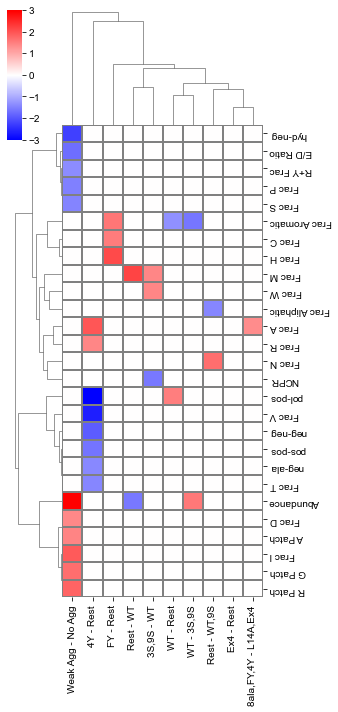

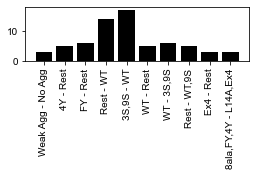

In [15]:
# Plot the features that are significant for one variant vs all the rest
# And other groups based on stability / phase separating ability


# Get list of proteins for all pairs that are significantly different from ANOVA and FishersLSD
myfile='../../data/UPOD_proteomics/anova_posthoc.xlsx'
df=pd.read_excel(myfile,'anova_posthoc_fix_double')
FishersLSD = df['Fishers LSD'].tolist()
Proteins = df['Proteins'].tolist()

# For one variant vs all rest
variants=['WT','9S','3S','L14A','Ex4','8ala','FY','4Y']
allnum=len(variants)-1

compair=[]
compairwempties=[]
allproteinpairs=[]
allproteinpairswempties=[]
for v1 in variants:
    currproteinsgt=[]
    currproteinslt=[]
    for i in range(0,len(FishersLSD)):
        currnumgt=0
        currnumlt=0
        for v2 in variants:
            if v1 != v2:
                currpairgt=v1+' - '+v2
                if currpairgt in FishersLSD[i]:
                    currnumgt=currnumgt+1
                    
                currpairlt=v2+' - '+v1
                if currpairlt in FishersLSD[i]:
                    currnumlt=currnumlt+1
                    
        if currnumgt==allnum:
            currproteinsgt.append(Proteins[i])
            
        if currnumlt==allnum:
            currproteinslt.append(Proteins[i])
            
    if currproteinsgt:
        compair.append(v1+' - Rest')
        compairwempties.append(v1+' - Rest')
        allproteinpairs.append(currproteinsgt)
        allproteinpairswempties.append(currproteinsgt)
    else:
        compairwempties.append(v1+' - Rest')
        allproteinpairswempties.append(currproteinsgt)
        
        
    if currproteinslt:
        compair.append('Rest - '+v1)
        compairwempties.append('Rest - '+v1)
        allproteinpairs.append(currproteinslt)
        allproteinpairswempties.append(currproteinslt)
    else:
        allproteinpairswempties.append(currproteinslt)
        compairwempties.append('Rest - '+v1)

# Add in additional specific pairs
gtype=['WT,9S,3S - Agg','Agg - WT,9S,3S','WT,9S - Rest','Rest - WT,9S','3S,9S - Rest',
    'Rest - 3S,9S','3S,9S - WT','WT - 3S,9S','8ala,FY,4Y - L14A,Ex4','L14A,Ex4 - 8ala,FY,4Y',
    'Unfolded Agg - Unfolded No Agg','Unfolded No Agg - Unfolded Agg',
    'Weak Agg - No Agg','No Agg - Weak Agg',
    'Strong Agg - No Agg','No Agg - Strong Agg',
    'Strong Agg - Weak Agg','Weak Agg - Strong Agg',
    '8ala base - Rest','Rest - 8ala base','3S, 8ala, L14A - Rest']
glist=[['WT - L14A','WT - Ex4','WT - 8ala','WT - FY','WT - 4Y','9S - L14A','9S - Ex4','9S - 8ala','9S - FY','9S - 4Y','3S - L14A','3S - Ex4','3S - 8ala','3S - FY','3S - 4Y'],
    ['L14A - WT','Ex4 - WT','8ala - WT','FY - WT','4Y - WT','L14A - 9S','Ex4 - 9S','8ala - 9S','FY - 9S','4Y - 9S','L14A - 3S','Ex4 - 3S','8ala - 3S','FY - 3S','4Y - 3S'],
    ['WT - 3S','WT - L14A','WT - Ex4','WT - 8ala','WT - FY','WT - 4Y','9S - L14A','9S - Ex4','9S - 8ala','9S - FY','9S - 4Y','9S - 3S'],
    ['3S - WT','L14A - WT','Ex4 - WT','8ala - WT','FY - WT','4Y - WT','L14A - 9S','Ex4 - 9S','8ala - 9S','FY - 9S','4Y - 9S','3S - 9S'],
    ['3S - WT','3S - L14A','3S - Ex4','3S - 8ala','3S - FY','3S - 4Y','9S - WT','9S - L14A','9S - Ex4','9S - 8ala','9S - FY','9S - 4Y'],
    ['WT - 3S','L14A - 3S','Ex4 - 3S','8ala - 3S','FY - 3S','4Y - 3S','WT - 9S','L14A - 9S','Ex4 - 9S','8ala - 9S','FY - 9S','4Y - 9S'],
    ['3S - WT','9S - WT'],
    ['WT - 3S','WT - 9S'],
    ['8ala - L14A','8ala - Ex4','FY - L14A','FY - Ex4','4Y - L14A','4Y - Ex4'],
    ['L14A - 8ala','Ex4 - 8ala','L14A - FY','Ex4 - FY','L14A - 4Y','Ex4 - 4Y'],
    ['8ala - 3S','8ala - 9S','FY - 3S','FY - 9S','4Y - 3S','4Y -9S'],
    ['3S - 8ala','9S - 8ala','3S - FY','9S - FY','3S - 4Y','9S - 4Y'],
    ['L14A - WT','L14A - 3S','L14A - 9S','8ala - WT','8ala - 3S','8ala - 9S','FY - WT','FY - 3S','FY - 9S'],
    ['WT - L14A','3S - L14A','9S - L14A','WT - 8ala','3S - 8ala','9S - 8ala','WT - FY','3S - FY','9S - FY'],
    ['Ex4 - WT','Ex4 - 3S','Ex4 - 9S','4Y - WT','4Y - 3S','4Y - 9S'],
    ['WT - Ex4','3S - Ex4','9S - Ex4','WT - 4Y','3S - 4Y','9S - 4Y'],
    ['Ex4 - 8ala','Ex4 - FY','Ex4 - L14A','4Y - 8ala','4Y - FY','4Y - L14A'],
    ['8ala - Ex4','FY - Ex4','L14A - Ex4','8ala - 4Y','FY - 4Y','L14A - 4Y'],
    ['8ala - WT','8ala - L14A','8ala - Ex4','3S - WT','3S - L14A','3S - Ex4','9S - WT','9S - L14A','9S - Ex4','FY - WT','FY - L14A','FY - Ex4','4Y - WT','4Y - L14A','4Y - Ex4'],
    ['WT - 8ala','L14A - 8ala','Ex4 - 8ala','WT - 3S','L14A - 3S','Ex4 - 3S','WT - 9S','L14A - 9S','Ex4 - 9S','WT - FY','L14A - FY','Ex4 - FY','WT - 4Y','L14A - 4Y','Ex4 - 4Y'],
    ['3S - WT','3S - 9S','3S - FY','3S - Ex4','3S - 4Y','8ala - WT','8ala - 9S','8ala - FY','8ala - Ex4','8ala - 4Y','L14A - WT','L14A - 9S','L14A - FY','L14A - Ex4','L14A - 4Y']]

count=-1
for currgroup in glist:
    matchnum=len(currgroup)
    count=count+1
    currproteinlist=[]
    for i in range(0,len(FishersLSD)):
        currnum=0
        for g in currgroup:
            if g in FishersLSD[i]:
                currnum=currnum+1
        if currnum==matchnum:
            currproteinlist.append(Proteins[i])
            
    if currproteinlist:
        compair.append(gtype[count])
        compairwempties.append(gtype[count])
        allproteinpairs.append(currproteinlist)
        allproteinpairswempties.append(currproteinlist)
    else:
        allproteinpairswempties.append(currproteinlist)
        compairwempties.append(gtype[count])

#print(glist)       
print(compair)                    
print(allproteinpairs)
print(allproteinpairswempties)
#hi

myfeat=['pol-pol','pol-hyd','pol-pos','pol-neg','pol-aro','pol-ala','pol-pro','pol-gly','hyd-hyd','hyd-pos','hyd-neg','hyd-aro','hyd-ala','hyd-pro','hyd-gly','pos-pos','pos-neg','pos-aro','pos-ala','pos-pro','pos-gly','neg-neg','neg-aro','neg-ala','neg-pro','neg-gly','aro-aro','aro-ala','aro-pro','aro-gly','ala-ala','ala-pro','ala-gly','pro-pro','pro-gly','gly-gly','Frac A','Frac C','Frac D','Frac E','Frac F','Frac G','Frac H','Frac I','Frac K','Frac L','Frac M','Frac N','Frac P','Frac Q','Frac R','Frac S','Frac T','Frac V','Frac W','Frac Y','Frac K+R','Frac D+E','Frac Polar','Frac Aliphatic','Frac Aromatic','R/K Ratio','E/D Ratio','Frac Chain Expanding','FCR','NCPR','Hydrophobicity','Disorder Promoting','Iso point','PPII','A Patch','C Patch','D Patch','E Patch','F Patch','G Patch','H Patch','I Patch','K Patch','L Patch','N Patch','P Patch','Q Patch','R Patch','S Patch','T Patch','V Patch','Y Patch','RG Frac','R+Y Frac','R+Y Num','Abundance']

#Performs the two-sample Kolmogorov-Smirnov test for goodness of fit.
#This test compares the underlying continuous distributions F(x) and G(x) of two independent samples.
#two-sided: The null hypothesis is that the two distributions are identical, F(x)=G(x) for all x; the alternative is that they are not identical.

groupdf=pd.DataFrame()
count=-1
allproteinpairsgt2=[]
compairgt2=[]
for mygroup in allproteinpairs:
    count=count+1
    pvallks=np.zeros((len(myfeat)))
    for p in range(0,len(myfeat)): 

        groupvec=[]
        restvec=[]
        for a in acc:
            if a in mygroup:
                idx=acc.index(a)
                groupvec.append(zvecaa[idx,p])
            else:
                idx=acc.index(a)
                restvec.append(zvecaa[idx,p])

        if p==0:
            print(len(groupvec))
            print(len(restvec))

        tmp=ks_2samp(groupvec, restvec, alternative='two-sided', mode='auto')
        if tmp.pvalue<0.05 and np.median(groupvec)>np.median(restvec):
            pvallks[p]=-1*math.log10(tmp.pvalue)
        elif tmp.pvalue<0.05 and np.median(groupvec)<np.median(restvec):
            pvallks[p]=math.log10(tmp.pvalue)
        else:
            pvallks[p]=0
            if tmp.pvalue<0.05:
                print('Medians are same but significantly different, use mean instead')
                hi
    
    if len(groupvec)>2:
        groupdf[compair[count]]=pvallks
        allproteinpairsgt2.append(allproteinpairs[count])
        compairgt2.append(compair[count])

groupdf['Features']=myfeat   
    
print(groupdf)
minval=0
rslt_df = groupdf.loc[(groupdf.sum(axis=1) != 0)]
print(rslt_df)

df2=rslt_df
myflist=rslt_df['Features'].tolist()
df2.pop('Features')
print(myflist)

clust_map = sbn.clustermap(df2, metric="euclidean", method="ward",cmap='bwr',vmin=-3, vmax=3,figsize=(4, 10),linewidths=1, linecolor='grey',yticklabels=1,xticklabels=1)  

rowindex=clust_map.dendrogram_row.reordered_ind
print(rowindex)
seqlabels=myflist
sseqlabels=[]
for i in rowindex:
    sseqlabels.append(seqlabels[i])

plt.yticks(np.arange(0, len(sseqlabels), 1.0))
plt.setp(clust_map.ax_heatmap.get_yticklabels(), rotation=180)
plt.setp(clust_map.ax_heatmap.set_yticklabels(sseqlabels))
#plt.show()

plt.rcParams['pdf.fonttype'] = 42 # Makes text editiable
plt.rcParams['ps.fonttype'] = 42
plt.rcParams['font.sans-serif'] = "Arial"
plt.rcParams['font.family'] = "sans-serif"
#plt.savefig('Fig_6_significant_sequence_features_pairs_and_groups.pdf', dpi=300, transparent=True, bbox_inches='tight')


colindex=clust_map.dendrogram_col.reordered_ind
numseqs=[]
scompair=[]
for i in colindex:
    numseqs.append(len(allproteinpairsgt2[i]))
    scompair.append(compairgt2[i])

fig = plt.figure(figsize = (4, 1)) 
# creating the bar plot
plt.bar(scompair, numseqs, color ='black')  
plt.xticks(rotation = 90)
plt.rcParams['pdf.fonttype'] = 42 # Makes text editiable
plt.rcParams['ps.fonttype'] = 42
plt.rcParams['font.sans-serif'] = "Arial"
plt.rcParams['font.family'] = "sans-serif"
#plt.savefig('Fig_6_num_significant_sequence_features_pairs_and_groups.pdf', dpi=300, transparent=True, bbox_inches='tight')
#plt.show()
print(numseqs)

#import xlsxwriter
#workbook = xlsxwriter.Workbook('../../data/UPOD_proteomics/anova_FisherLSD_significant_non_pair_groups.xlsx')
#worksheet = workbook.add_worksheet()
#worksheet.write_row(0,0, compairwempties)
#count=-1
#for mygroup in compairwempties:
#    count=count+1
#    worksheet.write_column(1, count, allproteinpairswempties[count])
#    
#workbook.close()

## Plot Figure 6F

z-score fraction arginine distribution for proteins enriched in 4Y UPODs compared to all other UPODs vs z-score fraction arginine distribution of remaining proteins. 

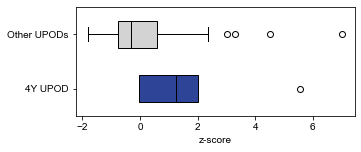

In [17]:
mygroup=['P06307','P61088','Q5JXB2','Q9NVI7','Q13243']

featidx=myfeat.index('Frac R')

valcheck=[]
valrest=[]
for a in acc:
    idx=acc.index(a)
    SeqOb = SequenceParameters(orthseqs[idx])
    aafrac=SeqOb.get_amino_acid_fractions()
    
    if a in mygroup:
        #valcheck.append((aafrac['R'])) # If want to plot by fraction
        valcheck.append(zvecaa[idx,featidx]) # If want to plot by z-score
    else:
        #valrest.append((aafrac['R'])) # If want to plot by fraction
        valrest.append(zvecaa[idx,featidx]) # If want to plot by z-score

my_dict = {'4Y UPOD': valcheck,'Other UPODs': valrest}

fig, ax = plt.subplots(figsize = (5, 2))
box=ax.boxplot(my_dict.values(),patch_artist=True,vert=0,widths=0.5)
colors = ['#2e4496','#d3d3d3']
for patch, color in zip(box['boxes'], colors):
    patch.set_facecolor(color)

for median in box['medians']:
    median.set_color('black')
    
ax.set_yticklabels(my_dict.keys())
plt.xlabel('z-score')

plt.rcParams['pdf.fonttype'] = 42 # Makes text editiable
plt.rcParams['ps.fonttype'] = 42
plt.rcParams['font.sans-serif'] = "Arial"
plt.rcParams['font.family'] = "sans-serif"
#plt.savefig('Fig_6_4Y_frac_R_zscore_boxplot.pdf', dpi=300, transparent=True, bbox_inches='tight')

z-score fraction aromatic distribution for proteins enriched in FY UPODs compared to all other UPODs vs z-score fraction aromatic distribution of remaining proteins. 

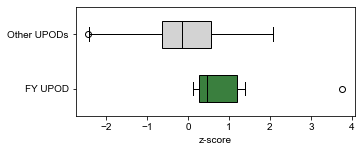

In [16]:
mygroup=['P24390','P55263','O75976','Q8N8Y2','Q9BW92','Q9Y676']

featidx=myfeat.index('Frac Aromatic')

valcheck=[]
valrest=[]
for a in acc:
    idx=acc.index(a)
    SeqOb = SequenceParameters(orthseqs[idx])
    aafrac=SeqOb.get_amino_acid_fractions()
    
    if a in mygroup:
        #valcheck.append((aafrac['F']+aafrac['W']+aafrac['Y'])) # If want to plot by fraction 
        valcheck.append(zvecaa[idx,featidx]) # If want to plot by z-score
    else:
        #valrest.append((aafrac['F']+aafrac['W']+aafrac['Y'])) # If want to plot by fraction 
        valrest.append(zvecaa[idx,featidx]) # If want to plot by z-score

my_dict = {'FY UPOD': valcheck,'Other UPODs': valrest}

fig, ax = plt.subplots(figsize = (5, 2))
box=ax.boxplot(my_dict.values(),patch_artist=True,vert=0,widths=0.5)
colors = ['#3a7f3e','#d3d3d3']
for patch, color in zip(box['boxes'], colors):
    patch.set_facecolor(color)

for median in box['medians']:
    median.set_color('black')
    
ax.set_yticklabels(my_dict.keys())
plt.xlabel('z-score')

plt.rcParams['pdf.fonttype'] = 42 # Makes text editiable
plt.rcParams['ps.fonttype'] = 42
plt.rcParams['font.sans-serif'] = "Arial"
plt.rcParams['font.family'] = "sans-serif"
#plt.savefig('Fig_6_FY_frac_aro_zscore_boxplot.pdf', dpi=300, transparent=True, bbox_inches='tight')


# Section 3: Plot data for Figures S5A and S5B

Figure S5A: Plot stacked bar graph for each of the top 5 enriched proteins for each barnase UPOD

                 0             1             2             3             4
4Y    1.839422e+07  3.344789e+06  3.278568e+06  2.794565e+06  1.292592e+06
Ex4   2.514224e+07  3.647908e+06  1.593983e+06  1.288590e+06  7.827589e+05
L14A  1.775998e+07  3.868631e+06  1.655094e+06  1.619752e+06  8.435645e+05
8ala  2.256709e+07  2.771240e+06  2.403528e+06  1.833488e+06  1.589652e+06
FY    3.692319e+07  3.695152e+06  2.913048e+06  1.576998e+06  1.337803e+06
3S    1.677633e+07  2.141415e+06  1.693347e+06  1.545900e+06  8.668177e+05
9S    6.492781e+06  2.001542e+06  1.701683e+06  1.403708e+06  9.063447e+05
WT    2.287043e+06  2.011297e+06  1.927614e+06  1.752082e+06  9.432732e+05


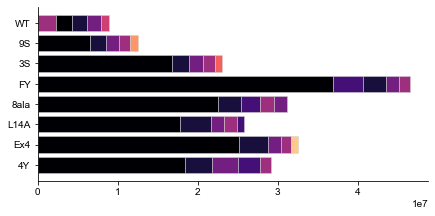

['3S', '4Y', '8ala', '9S', 'Ex4', 'FY', 'L14A', 'WT']
[['mTFP1', 'P0DMV9;P0DMV8', 'P40939', 'P16403;Q02539;P22492;P16401', 'P36578'], ['mTFP1', 'P0DMV9;P0DMV8', 'P40939', 'Q99832', 'P16403;Q02539;P22492;P16401'], ['mTFP1', 'P0DMV9;P0DMV8', 'Q99832', 'P16403;Q02539;P22492;P16401', 'P40939'], ['mTFP1', 'P0DMV9;P0DMV8', 'P40939', 'P16403;Q02539;P22492;P16401', 'O75947'], ['mTFP1', 'P0DMV9;P0DMV8', 'P40939', 'P16403;Q02539;P22492;P16401', 'P61247'], ['mTFP1', 'Q99832', 'P0DMV9;P0DMV8', 'P40939', 'P16403;Q02539;P22492;P16401'], ['mTFP1', 'P0DMV9;P0DMV8', 'P40939', 'P16403;Q02539;P22492;P16401', 'Q99832'], ['P16403;Q02539;P22492;P16401', 'mTFP1', 'P0DMV9;P0DMV8', 'P40939', 'O76021']]
['mTFP1', 'P0DMV9;P0DMV8', 'Q99832', 'P40939', 'P16403;Q02539;P22492;P16401', 'O76021', 'P36578', 'O75947', 'P61247']


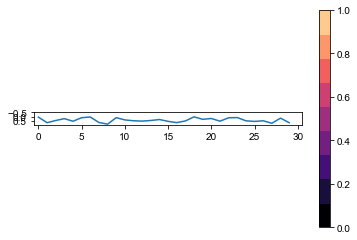

In [35]:
# Load in abundance data
myfile='../../data/UPOD_proteomics/Table_S5.xlsx'
df=pd.read_excel(myfile,'remove_barnase_CON_not_mTFP1')

accs = df['Proteins'].tolist()

df2=df.pop('Proteins')

colnames = df.columns
dfmat=df.values

# Get individual variants
reps=4
num_var=8
ucolnames=[]
for i in range(0,num_var):
    tmp=colnames[reps*i].split('_')
    ucolnames.append(tmp[0])

    
# Rename data
zmat=dfmat

# Get mean of abundances
st=[0,4,8,12,16,20,24,28,32]

dfMeanAbund=pd.DataFrame()
mzmat=[]
for r in zmat:
    submzmat=[]
    for i in range(0,len(st)-1):
        submzmat.append(np.mean(r[st[i]:st[i+1]]))
    mzmat.append(submzmat)

dfMeanAbund=pd.DataFrame(mzmat,columns=ucolnames)

numtop=5
topabundarray=np.zeros((len(ucolnames), numtop))

count=-1
toppro=[]
for c in ucolnames:
    count=count+1;
    mylist=dfMeanAbund[c].tolist()
    sorted_idx = [index for index, value in sorted(enumerate(mylist), reverse=True, key=lambda x: x[1])]
    #print(sorted_idx)
    tmp=[]
    for i in range(0,numtop):
        topabundarray[count,i]=mylist[sorted_idx[i]]
        tmp.append(accs[sorted_idx[i]])
    toppro.append(tmp)

# Get unique names in list
#utoppro=list({x for l in toppro for x in l})
# To set so that way the colors of the bars automatically match the manuscript figure
utoppro=['mTFP1', 'P0DMV9;P0DMV8', 'Q99832', 'P40939', 'P16403;Q02539;P22492;P16401', 'O76021', 'P36578', 'O75947', 'P61247']


#csatnames=['WT','9S','3S','FY','8ala','L14A','Ex4','4Y'] 
csatnames=['4Y','Ex4','L14A','8ala','FY','3S','9S','WT']

dftopabund=pd.DataFrame(index=ucolnames)
fields=[]
for i in range(0,numtop):
    dftopabund[str(i)]=topabundarray[:,i]
    fields.append(str(i))

# Reindex dataframe
dftopabund2 = dftopabund.reindex(csatnames)
print(dftopabund2)

# Reindex ids
stoppro=[]
for c in csatnames:
    curridx=ucolnames.index(c)
    stoppro.append(toppro[curridx])
    

#colors = ['#0f8041', '#118c42', '#159e4c', '#1cb75a','#20d368','#000000','#262626','#3f3f3f','#565656','#707070','#3b54a4','#4568bf','#ea2729','#f94851','#ffce09','#ffd939','#ffe164','#b8539f','#d663be','#e86dce']
#colors = ['#000000','#b72225','#c17629','#bab733','#3a7f3e','#2e4496','#8d5ca6','#cd4c53','#000000']
cm = plt.get_cmap('magma')
colors=[cm(1.*i/len(utoppro)) for i in range(len(utoppro))]
# figure and axis
fig, ax = plt.subplots(1, figsize=(7, 3.2))
# plot bars
left = len(dftopabund2) * [0]
for i in range(0,len(fields)):
    currcolors=[]
    for v in range(0,len(csatnames)):
        currprotein=stoppro[v][i]
        curridx=utoppro.index(currprotein)
        currcolors.append(colors[curridx])
    plt.barh(dftopabund2.index, dftopabund2[fields[i]], left = left, color=currcolors,edgecolor = '#d3d3d3',linewidth=0.5)
    left = left + dftopabund2[fields[i]]


# remove spines
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)

plt.yticks(np.arange(0, len(csatnames), 1), csatnames)

plt.rcParams['pdf.fonttype'] = 42 # Makes text editiable
plt.rcParams['ps.fonttype'] = 42
plt.rcParams['font.sans-serif'] = "Arial"
plt.rcParams['font.family'] = "sans-serif"
#plt.savefig('Highest_5_Protein_Abundance_Stacked.pdf', dpi=300, transparent=True, bbox_inches='tight')

plt.show()

newcmp=ListedColormap(colors)
img = plt.imshow(np.array([[0,1]]), cmap=newcmp)
img.set_visible(False)

plt.colorbar(orientation="vertical")

# add any other things you want to the figure.
plt.plot(np.random.rand(30))

plt.rcParams['pdf.fonttype'] = 42 # Makes text editiable
plt.rcParams['ps.fonttype'] = 42
plt.rcParams['font.sans-serif'] = "Arial"
plt.rcParams['font.family'] = "sans-serif"
#plt.savefig('Highest_5_Protein_Abundance_Stacked_Colorbar.pdf', dpi=300, transparent=True, bbox_inches='tight')

print(ucolnames)
print(toppro)
print(utoppro)


Figure S5B: Plot mean distance between abundance vectors for each pair of barnase UPODs

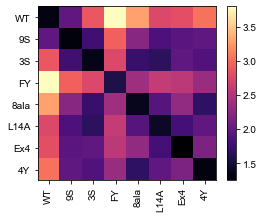

In [55]:
# Get clustered z-score abundances and compare abundance vectors
myfile='../../data/UPOD_proteomics/Table_S5.xlsx'
df=pd.read_excel(myfile,'remove_barnase_5_CON') # removes the 5 proteins associated with barnase
accs = df['Proteins'].tolist()

df2=df.pop('Proteins')

colnames = df.columns
dfmat=df.values

# For log10 values
zmat=[]
for r in dfmat:
    ztmp=[]
    for i in r:
        ztmp.append(math.log10(i))
    zmat.append(ztmp)

# For log10 abundance data cluster the abundance vectors to see which barnase constructs are most similar
df4=pd.DataFrame(zmat,columns=colnames)

dist_array=pdist(df4.T,"euclidean")
dist_matrix = squareform(dist_array)
tmp=np.array(dist_matrix)

# Get mean distance between all replicas
reps=4
num_var=8
ucolnames=[]
for i in range(0,num_var):
    tmp=colnames[reps*i].split('_')
    ucolnames.append(tmp[0])

csatnames=['WT','9S','3S','FY','8ala','L14A','Ex4','4Y']    

#print(dist_matrix[0:8,0:4])
    
num_var=len(ucolnames)
n_dist_matrix=np.array(dist_matrix)
mdist=[]
sdist=[]
dfdist=pd.DataFrame()
mean_dist_array = np.zeros([num_var, num_var])
for i in range(0,num_var):
    for j in range(0,num_var):
        idx1=csatnames.index(ucolnames[i])
        idx2=csatnames.index(ucolnames[j])
        tmp=[]
        if i != j:
            for r1 in range(0,reps):
                for r2 in range(0,reps):
                    tmp.append(n_dist_matrix[reps*i+r1,reps*j+r2])
            #print(tmp) 
        if i == j:
            for r1 in range(0,reps):
                for r2 in range(r1+1,reps):
                    tmp.append(n_dist_matrix[reps*i+r1,reps*j+r2])
            #print(tmp)        
        mean_dist_array[idx1,idx2]=np.mean(tmp)
    
#print(mean_dist_array)

fig = plt.figure(figsize = (4, 3.2)) 
plt.pcolor(mean_dist_array,cmap='magma')
plt.gca().invert_yaxis()
#plt.pcolor(mean_dist_array,vmin=-3, vmax=3,cmap='Greens',edgecolors='grey', linewidths=2)
plt.colorbar()
plt.yticks(np.arange(0.5, len(csatnames), 1), csatnames)
plt.xticks(np.arange(0.5, len(csatnames), 1), csatnames,rotation=90) 

plt.rcParams['pdf.fonttype'] = 42 # Makes text editiable
plt.rcParams['ps.fonttype'] = 42
plt.rcParams['font.sans-serif'] = "Arial"
plt.rcParams['font.family'] = "sans-serif"
#plt.savefig('Distance_bt_log10_vectors_matrix_top_94.pdf', dpi=300, transparent=True, bbox_inches='tight')

## Section 4: Get fraction of proteins with a disorder stretch > 50

In [70]:
disacc=[]
myfile = open('../../data/UPOD_proteomics/disorder_min_length_30_sapiens', 'r')
Lines = myfile.readlines()

for line in Lines:
    fullline=line.split(" ")
    tmp=fullline[0]
    tmp2=tmp.split('_')
    tmpseq=fullline[3]
    currseq=tmpseq.strip('\n')
    if len(currseq)>50:
        disacc.append(tmp2[0])      
        
# Load in abundance data
myfile='../../data/UPOD_proteomics/Table_S5.xlsx'
df=pd.read_excel(myfile,'remove_barnase_5_CON') # removes the 5 proteins associated with barnase

accs = df['Proteins'].tolist()

splitaccs=[]
for a in accs:
    tmp=a.split(";")
    splitaccs.append(tmp[0])
    
countdis=0
for a in splitaccs:
    if a in disacc:
        countdis=countdis+1
        print(a)
        
print(countdis)
print((len(splitaccs)-countdis))
print((len(splitaccs)-countdis)/len(splitaccs))

Q96I25
P49674
Q9NQ29
P49959
Q9BUP0
Q9NZL4
Q1KMD3
Q9Y6Y8
Q9Y5B9
P55010
Q8TDD1
Q12893
Q9NWT1
Q04323
Q92917
Q8WXX5
Q13523
P36578
Q9Y2W1
O00567
P07305
P16403
O76021
P22087
Q16629
Q9NVI7
Q13243
P67809
28
66
0.7021276595744681
